# BLU15 - Model CSI

In [128]:
import os
import pandas as pd
import numpy as np
import io
import json
import pickle
import requests
import joblib
import math
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.metrics import precision_score, recall_score, precision_recall_curve
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
from scipy.stats import ks_2samp


# for evaluation purposes
import hashlib
from plotchecker import LinePlotChecker, ScatterPlotChecker, BarPlotChecker

def _hash(s):
    return hashlib.blake2b(
        bytes(str(s), encoding='utf8'),
        digest_size=5
    ).hexdigest()

In the previous BLUs we've been working with the _"Velho Banco"_ dataset, with the goal of design a system that tries to predict if a given individual earns more than 50K a year. 

As a reminded, each row in the dataset is about a client, and here's the attibute information:

    1) age 
    2) workclass - type of work performed by client (eg. `Private`)
    3) fnlwgt - chest pain type (4 values)
    4) education - level of education of client (eg. `Bachelors`)
    5) education-num - 
    6) marital-status - client's marital status (eg `Widowed`)
    7) occupation - type of job held by client (eg. `Craft-repair`)
    8) relationship - 
    9) race - client's race
    10) sex - "male"/"female"
    11) capital-gain - total capital gain in previous year
    12) capital-loss - total capital loss in previous year
    13) hours-per-week - number of hours the client works per week
    14) native-country - client's original nationality (eg. `Portugal`)

Your original dataset is located in `data/bank.csv`


Recently your client has just provided you with a new set of observations, located in `data/bank_new_observations.csv`. This is your goal:

- Assess how your model performs with the new dataset
- Assess if there has been any changes to the data 
- Deploy a new model

**Note:** Your first step of **assessing how your original model performs with the new dataset** will be ungraded as, in fear of spoiling the fun of solving BLU14 on your own, we'll be skipping this step. ;) 

Start by loading the old and new data and have a quick look at it! 

In [129]:
def load_data(file):
    df = pd.read_csv(os.path.join("data", file))
    return df
df_original = load_data("bank.csv")
df_new = load_data("bank_new_observations.csv")
target='salary'
df_new.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary
0,26,Private,279145,HS-grad,9,Married-civ-spouse,Craft-repair,Husband,White,Male,0,0,50,United-States,<=50K
1,36,Private,178815,Bachelors,13,Never-married,Exec-managerial,Not-in-family,White,Male,8614,0,40,United-States,>50K
2,25,Self-emp-not-inc,245369,HS-grad,9,Separated,Craft-repair,Own-child,White,Male,0,0,35,United-States,<=50K
3,30,Federal-gov,49593,Prof-school,15,Never-married,Prof-specialty,Not-in-family,Black,Female,0,0,40,United-States,<=50K
4,46,State-gov,238648,HS-grad,9,Married-civ-spouse,Other-service,Husband,Black,Male,7298,0,40,United-States,>50K


## Exercise 1

One of the most important things is to check if the data has changed over time. This data is not timestamped, so the approach we'll be following is to check if the distribution has changed from one dataset to the other. Let's begin!

**Important note about the grading**
Grading plots is difficult! We are using [`plotchecker`](https://github.com/jhamrick/plotchecker) to grade the plots with `nbgrader`. For `plotchecker` to work with nbgrader, we need to add on each cell, the line

```
axis = plt.gca();
````

After the code required to do the plot.

### Exercise 1.1

Start by building a funtion to plot the histogram of a given feature for each dataset.

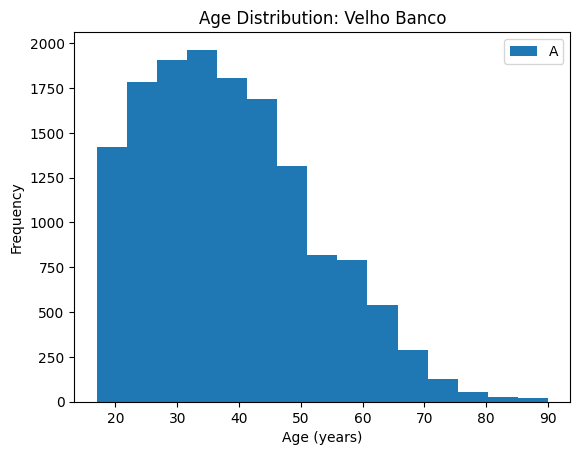

In [130]:
def generate_distribution_histogram(dataframe, 
                                    column_name, 
                                    title, x_axis_label, y_axis_label,
                                    label_name,
                                    number_bins = 15):
    """
    This function generates a histogram.
    Args:
        dataframe:
        column_name: String. Name of the column whose distribution we
        want to visualize.
        title: String. Title of the histogram.
        x_axis_label: String. X-axis label.
        y_axis_label: String. Y-axis label.
    Outputs:
        Histogram containing distribution for specific column column_name.
    """
    plt.hist(dataframe[column_name], bins = number_bins)
    plt.title(title)
    plt.xlabel(x_axis_label)
    plt.ylabel(y_axis_label)
    plt.legend(label_name, loc='upper right')
    axis = plt.gca();
    return axis

axis = generate_distribution_histogram(df_new, 'age',
                                title = 'Age Distribution: Velho Banco',
                                x_axis_label = 'Age (years)',
                                y_axis_label = 'Frequency',
                                label_name = 'Age')

In [131]:
pc = BarPlotChecker(axis)
l = [pc.xlabel] + [pc.ylabel]
l.sort()

assert _hash(pc.title) == 'b5c996841f', "Did you set the right title?"
assert _hash(l) in ['2867b32d42'], "Did you set the right variables for the plot axes?"
try:
    pc.assert_num_bars(15)
except:
    "Did you set the right number of bins?"
assert _hash(pc.centers) == 'c705138d5b' and _hash(pc.heights) == '2e4053a844', "Did you set the right variable or the right plot type?"

## Exercise 1.2
Let's use the same code to look at the "Age" variable of the new and original data. 

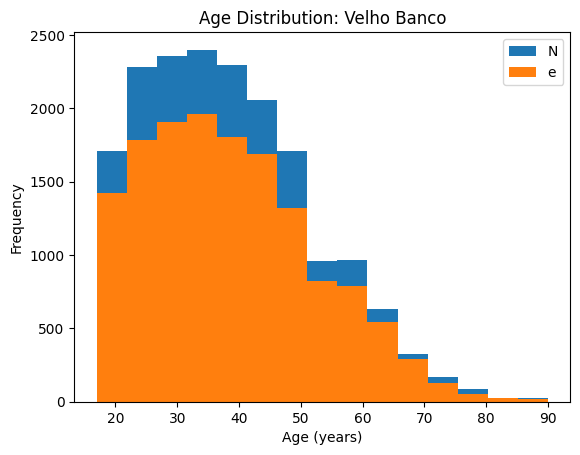

In [132]:
axis = generate_distribution_histogram(df_original, 'age',
                                title = 'Age Distribution: Velho Banco',
                                x_axis_label = 'Age (years)',
                                y_axis_label = 'Frequency',
                                label_name = 'Original data')
axis = generate_distribution_histogram(df_new, 'age',
                                title = 'Age Distribution: Velho Banco',
                                x_axis_label = 'Age (years)',
                                y_axis_label = 'Frequency',
                                label_name = 'New data')

Do you think there was a change in the distribution? Answer with `"yes"` or `"no"`.

In [133]:
answer_1_2 = 'no'

In [134]:
assert _hash(answer_1_2.lower()) == '0fe736fa82', "Look again!"

## Exercise 1.3

How sure are you about your answer to the previous question? Odds are that you picked the option that passed the assert. ;) That's why statistics is here! 

As we covered in the learning notebook, the K-S Statistic is a useful tool to check if the upcoming new data belongs to the same distribution as that of training data. Let's use this instead.

>If the K-S statistic p-value is high (>0.05), then we cannot reject the hypothesis that the distributions of the two samples are the same.

**hint:** We need the [stats.ks_2samp](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ks_2samp.html) test!

In [135]:
def get_ks_test(feature, training_df, new_df):
    """
    This function returns the result of the k-s statistic for the same feature in two datasets.
    Args:
        feature: feature name
        training_df: dataframe used to train the model
        new_df: dataframe with the new data
    Outputs:
        P-value of the K-S statistic for feature in training_df and new_df
    """
    stat = ks_2samp(training_df[feature], new_df[feature])
    pvalue = stat[1]

    return pvalue
    
pvalue = get_ks_test('age', df_original, df_new)
pvalue

0.9331439540471267

In [136]:
assert isinstance(pvalue, float), "are you returning just the p-value?"
assert math.isclose(pvalue, 0.9331, abs_tol=.01), "Something is wrong. are you returning the p-value or the the k-s test value? we want the first"

With a p-value as high as this, it's pretty safe to say that for the age, there has been no difference in the distribution of values. What about the other features?

### Exercise 1.4

Using the function above, check if there is any significant change in any feature distribution for the new and training datasets. 

**Save the results in a dictionary, and don't forget to exclude the target variable.**

In [137]:
features = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
'marital-status', 'occupation', 'relationship', 'race', 'sex',
'capital-gain', 'capital-loss', 'hours-per-week', 'native-country']

In [138]:
ks_test_dict = {}
for feature in features:
    pvalue = get_ks_test(feature, df_original, df_new)
    ks_test_dict[feature] = pvalue
ks_test_dict

{'age': 0.9331439540471267,
 'workclass': 0.9982912988769289,
 'fnlwgt': 0.38066442390107513,
 'education': 0.2449128897330588,
 'education-num': 0.6840815629987997,
 'marital-status': 1.0,
 'occupation': 0.27171705969147064,
 'relationship': 0.9905809230149224,
 'race': 0.9743279056060377,
 'sex': 1.0,
 'capital-gain': 0.9996458453867124,
 'capital-loss': 1.0,
 'hours-per-week': 0.9371979803083827,
 'native-country': 0.9999762326014933}

In [139]:
assert isinstance(ks_test_dict, dict)
assert _hash(sorted(ks_test_dict.keys())) == '5ca69ca620', "Have you excluded the target variable?"
assert math.isclose(sum(ks_test_dict.values()), 11.41, abs_tol=.01), "Are you saving the p-value? Is it being calculated correctly?"

In [140]:
for k,v in ks_test_dict.items():
    if v < 0.005:
        print("Feature {} has changed significantly!")

Now we can safely say that we do not have a case of data drift in our hands. At least with the very basic tests that we've done. Even though if nothing has changed in the data distribution, we still have more data and we should take advantage of it! 

## Exercise 2

Combine the two datasets into one. Add a new column called `is_new` that is going to have all `False` values for the old data and all `True` values for the new observations.

In [141]:
df_original['is_new'] = False
df_new['is_new'] = True
df_combined = pd.concat([df_original, df_new], axis=0)



In [142]:
df_combined.head(3)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,salary,is_new
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K,False
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K,False
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K,False


In [143]:
assert df_combined.shape == (32561, 16), 'Combined dataframe shape is wrong.'
assert 'is_new' in df_combined.columns, 'Did you add is_new column?'
assert sum(df_combined['is_new']) == 14561, 'is_new column has a wrong number of True values'

In total we have now 32561 observations. This dataset is still small enough that we do not have to do any data selection to retrain our model, but the same might not be true for future iterations. ;)

### Exercise 3

Split the created dataset on train and test parts in the following way:

- Make sure to change the target so that it has a binary value - True or False - instead of the original values. In particular:
    - False: client has as a salary of less or equal to 50K
    - True: client has as a salary higher than 50K
- Firstly create train and test set. Call them `df_train` and `df_test`. We'll need them in the future exercises.
- Then, split train and test into `X_train`, `X_test`, `y_train` and `y_test`.
    - Test sets shape should be 25% of df_combined shape
    - Make sure to have 25% of new values in the test size.
    - Use random state 42 while splitting the datasets

In [144]:
df_combined['salary'] =  df_combined['salary'].apply(lambda x: False if x == '<=50K' else True)

In [145]:
# YOUR CODE HERE
df_train, df_test = train_test_split(df_combined, test_size=0.25, random_state=42, stratify=df_combined['is_new'])

In [146]:
train_features = df_combined.columns.drop('salary')
targer = 'salary'
X_train = df_train[train_features]
y_train = df_train[target]
X_test = df_test[train_features]
y_test = df_test[target]

In [147]:
assert df_train.shape == (24420, 16), 'df_train shape is wrong. Are you sure test size is 25%?'
assert df_train[target].dtype == 'bool', "Have you changed the target variable to binary?"
assert df_test.shape == (8141, 16), 'df_test shape is wrong. Are you sure test size is 25%?'
assert df_test[target].dtype == 'bool', "Have you changed the target variable to binary?"
assert X_train.shape == (24420, 15), 'X_train shape is wrong. Are you sure test size is 25%?'
assert X_test.shape == (8141, 15), 'X_test shape is wrong. Are you sure test size is 25%?'
assert y_train.shape == (24420,), 'X_train shape is wrong. Are you sure test size is 25%?'
assert y_test.shape == (8141,), 'X_train shape is wrong. Are you sure test size is 25%?'
assert sum(X_train['is_new']) == 10920, 'is_new column in Training set has a wrong number of True values. Make sure to have 25% of new values'
assert sum(X_test['is_new']) == 3641, 'is_new column in Test set has a wrong number of True values. Make sure to have 25% of new values'

In [148]:
df_train[target].dtype == 'bool'

True

## Exercise 4
Now we need to retrain the model.
If we simply load the pipeline you created from BLU14 and retrain it, it's going to ignore our new feature.
So let's create the same pipeline as in the previous BLU Exercise notebook:

    Build a baseline model for this problem (don't worry about performance for now) and serialize it. Use the following features:

        1) age 
        2) workclass - type of work performed by client (eg. `Private`)
        4) education - level of education of client (eg. `Bachelors`)
        6) marital-status - client's marital status (eg `Widowed`)
        9) race - client's race
        10) sex - "male"/"female"
        11) capital-gain - total capital gain in previous year
        12) capital-loss - total capital loss in previous year
        13) hours-per-week - number of hours the client works per week

    Note: If you use models or functions that have a random component, ensure that you pass a random state so that there are no surprises when you submit
    

In [149]:
# This is a temporary directory where your serialized files will be saved. Make sure you use this as 
# the target folder when you serialize your files
TMP_DIR = '/tmp'

In [150]:
columns = ['age', 'workclass', 'education', 'marital-status', 'race', 
'sex', 'capital-gain', 'capital-loss', 'hours-per-week']

In [151]:

#X_train = X_train.loc[:, columns]

In [152]:
#numerical_features = X_train.select_dtypes(include=np.number).columns.tolist()
#categorical_features = X_train.select_dtypes(exclude=np.number).columns.tolist()

numerical_features = ['age', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'race', 'sex']

numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
)

In [153]:
assert isinstance(pipeline, Pipeline)

In [154]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                           

## Exercise 5
Now let's test how the model performs with the fresh new data! Here's your TODO list:

- Make model binary predictions and save them to an array called `preds`.
- Make model probability predictions and save them to an array called `preds_proba`. **Keep only True class probabilities** (by default probability prediction returns you both False and True classes probabilities)
- Create a variable called precision with the model precision score.
- Create a variable called recall with the model recall score

In [155]:
preds = pipeline.predict(X_test)
preds_proba = pipeline.predict_proba(X_test)[:, 1] #probability of being true
precision = precision_score(y_test, preds, pos_label=True)
recall = recall_score(y_test, preds)


In [156]:
precision

0.47148503670242803

In [157]:
assert math.isclose(recall, 0.86, abs_tol=.01), "Your recall value is too far off. Is your pipeline correctly set?"
assert len(preds) == 8141, 'Are you sure you made predictions for test set only?'
assert len(preds_proba) == 8141, 'Are you sure you made predictions for test set only?'
assert not isinstance(preds_proba[0], np.ndarray), 'Are you sure you kept only the True class predictions?'
assert round(sum(preds_proba)) == 3609
assert math.isclose(precision, 0.47, abs_tol=.01), "Your precision value is too far off. Is your pipeline correctly set?"
assert math.isclose(recall, 0.86, abs_tol=.01), "Your recall value is too far off. Is your pipeline correctly set?"

## Exercise 6
Let's now try to calculate the optimal threshold. By threshold I mean the minimal probability of a prediction that we're going to call "True".

By default, any prediction with probability > 0.5 is called True, but we might find a better value.

The metric is the same: our success rate (precision) needs to be at least 50%, and the recall should be as big as possible.

Save the result to a variable called threshold. Round the result to 2 decimal points.

In [158]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_proba)

In [159]:
print(len(precision), len(recall), len(thresholds))

2486 2486 2485


In [160]:
precision = precision[:-1]
recall = recall[:-1]

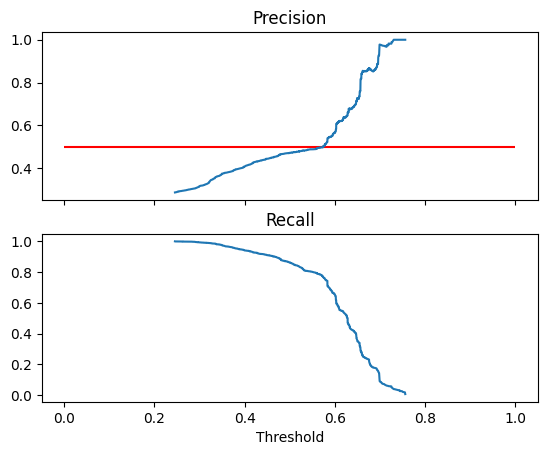

In [161]:
fig=plt.figure()
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.hlines(y=0.5,xmin=0, xmax=1, colors='red')
ax1.plot(thresholds,precision)
ax2.plot(thresholds,recall)
ax1.get_shared_x_axes().join(ax1, ax2)
ax1.set_xticklabels([])
ax1.set_title('Precision')
ax2.set_title('Recall')
plt.xlabel('Threshold')
plt.show()

In [162]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]

In [163]:
threshold = round(thresholds[min_index], 2)

In [164]:
threshold

0.57

In [165]:
assert round(threshold, 2) == threshold, 'Did you round the value?'
ans_threshold = hashlib.sha256(bytes(str(threshold), encoding='utf8')).hexdigest()
assert ans_threshold == '37f253d59e6203142bd9b0b9a7ac8044b7217baca69cfc9846e3748a3f804cc0'

## Exercise 7:
Now create a list of predictions. 

- All the values from the **preds_proba** list that have a value > threshold should be True. The rest should be False. Save the result to a variable called **best_preds**
- Calculate the precision and recall and save them to variables **precision** and **recall**

In [166]:
best_preds = [1 if pred > threshold else 0 for pred in preds_proba]
precision = precision_score(y_test, best_preds, pos_label=True)
recall = recall_score(y_test, best_preds)

In [167]:
np.testing.assert_almost_equal(precision, 0.4963, decimal=2)
np.testing.assert_almost_equal(recall, 0.7790, decimal=2)

## Exercise 8

Now let's find out whether removing rare values is going to help. 

**Filter *df_train* (the one you created in the Exercise 3) the following way:** 

- Remove rows with **education** that appear <= 50 times
- Remove rows with **marital-status** that appear <= 30 times

**Note: it's better to keep the original dataframe not touched. Create a copy of the original dataframe and save the results to a variable **train_filtered**

> We have to filter the values after we split the dataset into training and test, because by filtering the test set we also affect the score. If we filtered everything besides the examples that are the easiest to predict, we'd have a super nice score, but in production we're going to expect both the filtered values and unfiltered ones. 

> We shouldn't worry about the fact, that some values in the test set will not be present in the training set, because the pipeline is simply going to ignore them.

> (you might use the logic from the original model's notebook, but I suggest trying to implement it by yourself, it's a good exercise)

In [168]:
min_frequency = {
    "education": 50,
    "marital-status": 30
}

In [169]:
def filter_values(df: pd.DataFrame, column_name: str, threshold: int):
    value_counts = df[column_name].value_counts()
    to_keep = value_counts[value_counts >= threshold].index
    filtered = df[df[column_name].isin(to_keep)]
    return filtered

In [170]:
train_filtered = df_train.copy()
for feature, threshold in min_frequency.items():
    train_filtered = filter_values(train_filtered, feature, threshold)

In [171]:
assert train_filtered.shape == (24365, 16), 'Make sure to filter rare values. Make sure to filter only train set.'
assert 'Preschool' not in train_filtered['education'], 'Did you filter education?'
assert 'Married-AF-spouse' not in train_filtered['marital-status'], 'Did you filter marital-statu?'

In [172]:
train_filtered.shape

(24365, 16)

## Exercise 9

The workclass has several values that represent the same information. It might be beneficial to merge them.

- Merge the "?", "Without-pay" and "Never-worked" into a single "No Salary" category

In [173]:
train_filtered['workclass'] = train_filtered['workclass'].replace(['?', 'Never-worked', 'Without-pay'], 'No Salary')

In [174]:
assert len(train_filtered['workclass']) == 24365
assert len(train_filtered['workclass'][train_filtered['workclass'] == "No Salary"]) == 1421

## Exercise 10

**Let's split *train_filtered* into *X* and *Y* parts and do the same thing once again:**

- Fit the model on the training set (this time filtered one)

- Predict probabilities for the test set (untouched one).

- Select the best threshold for the specified requirements (precision >= 0.5, max possible recall).

- Round up the threshold up to 2 decimal points.

- Transform probabilities to binary answers: probability above the threshold = True, False otherwise.

- Calculate the precision and recall scores for these predictions. 

I believe you need no exact instructions, as you did exactly same things in Exercises 3, 4 and 5. ;)

Save the score results to variables called **filtered_precision** and **filtered_recall**

In [175]:
X_train = train_filtered[train_features]
y_train = train_filtered[target]

In [176]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                           

In [177]:
preds_proba = pipeline.predict_proba(X_test)[:, 1] #probability of being true

In [178]:
precision, recall, thresholds = precision_recall_curve(y_test, preds_proba)

In [179]:
precision = precision[:-1]
recall = recall[:-1]

In [180]:
min_index = [i for i, prec in enumerate(precision) if prec >= 0.5][0]

In [181]:
threshold = round(thresholds[min_index], 2)

In [182]:
filt_preds = [1 if pred > threshold else 0 for pred in preds_proba]
filtered_precision = precision_score(y_test, filt_preds, pos_label=True)
filtered_recall = recall_score(y_test, filt_preds)

In [183]:
np.testing.assert_almost_equal(filtered_precision, 0.5046, decimal=2)
np.testing.assert_almost_equal(filtered_recall, 0.75581, decimal=2)

## Exercise 11

So, we got the model, and our precision is now above the needed treshold! It's usually a good idea to **retrain the model on the whole dataset**, so now I want you to:
- Apply the filters that you just created in the Exercise 8 to **df_combined**
- Apply the transformation to the workclass to **df_combined**
- Train the same model on the whole dataset
- Export the model, train columns and data types to **/tmp/<file_name>**, where files are called **new_pipeline.pickle**, **new_dtypes.pickle** and **new_columns.json**.

In [184]:
for feature, threshold in min_frequency.items():
    df_combined = filter_values(df_combined, feature, threshold)

In [185]:
df_combined['workclass'] = df_combined['workclass'].replace(['?', 'Never-worked', 'Without-pay'], 'No Salary')

In [186]:
X = df_combined[train_features]
y = df_combined[target]

In [187]:
pipeline.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['age', 'capital-gain',
                                                   'capital-loss',
                                                   'hours-per-week']),
                                                 ('cat',
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['workclass', 'education',
                           

In [188]:
with open('/tmp/new_columns.json', 'w') as fh:
    json.dump(X.columns.tolist(), fh)

with open('/tmp/new_dtypes.pickle', 'wb') as fh:
    pickle.dump(X.dtypes, fh)

joblib.dump(pipeline, '/tmp/new_pipeline.pickle')

['/tmp/new_pipeline.pickle']

In [189]:
with open(os.path.join(TMP_DIR, 'new_columns.json')) as fh:
    columns = json.load(fh)

with open(os.path.join(TMP_DIR, 'new_pipeline.pickle'), 'rb') as fh:
    pipeline = joblib.load(fh)

with open(os.path.join(TMP_DIR, 'new_dtypes.pickle'), 'rb') as fh:
    dtypes = pickle.load(fh)

assert isinstance(columns, list), 'columns need to be a list of training features'
assert 'salary' not in columns, 'there should be only training features in columns. You got target there.'
assert 'is_new' in columns, "your columns don't contain is_new feature. Are you you updated the columns file?"
assert isinstance(pipeline, Pipeline), 'new_pipeline.pickle does not seem it be an instance of Pipeline class.'
assert isinstance(dtypes, pd.core.series.Series)
assert all([column in dtypes.index for column in columns]), 'some columns from new_columns file are not in the new_dtypes file'
assert all([dtype in columns for dtype in dtypes.index]), 'some dtypes from new_dtypes file are not in the new_columns file'

## Exercise 12 (ungraded)
And now it's time to change the server! I know you missed this part :)

Before we do it, I want to remind you that in this exercise we didn't cover the ethics topic. Our model is trained on sensible features like race and sex. In a real situation you'd need to make sure that your model is not discriminating anyone.

Now, go and create a copy of the protected_server.py file. Call it new_server.py

In that file:

- Change the check_valid_column function to have the new added columns You can also automate it by reading the columns file, it's even better!

- Change the check_categorical_values function: Make sure the values there still make sense!

- We also add one more categorical feature to the dataframe (is_new). Go and add possible values to the check.

As soon as it's done, go ahead and start the server.

Play with the predictions. Make sure that the server checks the is_new feature values. Try to send requests without is_new or with a different value (not True or False).

After you're done, change the value of done to True to pass the exercise!

In [190]:
done = True

In [191]:
assert done == True

There's much more we can do with this dataset to train a better model, and more importantly, a model that doesn't descriminate. So if you're willing, go crazy! Make the best model you can! It's great preparation for the hackathon! ;) See you there!